# Strategic Capacity Framework for Premium Lounge Expansion

## Problem Statement: Regime-Aware Forecasting & Nonlinear Congestion Modeling

Author: Sanidhya Mathur
# Objective:
Quantify how premium portfolio growth interacts with airport lounge
capacity constraints under nonlinear congestion dynamics.

This notebook:
1. Establishes a stabilized passenger baseline (post-COVID regime)
2. Translates passenger volume into lounge demand
3. Models peak occupancy using queueing approximations
4. Identifies nonlinear overflow thresholds
5. Quantifies capital expansion triggers

## Data Sources

• Airport passenger dataset: Real public dataset (DATA.GOV).

• Premium card penetration, lounge preference, and behavioral parameters: Synthetic assumptions used solely for structural sensitivity demonstration.

Passenger forecasting is fully data-driven using historical airport statistics (1999–2023). Lounge demand translation (card penetration, visit propensity, peak clustering) is scenario-based and used for structural sensitivity testing rather than point prediction.


In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look nicer
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

In [223]:
from google.colab import files
uploaded = files.upload()

Saving Air_Traffic_Passenger_Statistics.csv to Air_Traffic_Passenger_Statistics (2).csv


In [224]:
df = pd.read_csv("Air_Traffic_Passenger_Statistics.csv")

In [225]:
print(df.shape)
print(df.columns)
df.head()

(35030, 15)
Index(['Activity Period', 'Activity Period Start Date', 'Operating Airline',
       'Operating Airline IATA Code', 'Published Airline',
       'Published Airline IATA Code', 'GEO Summary', 'GEO Region',
       'Activity Type Code', 'Price Category Code', 'Terminal',
       'Boarding Area', 'Passenger Count', 'data_as_of', 'data_loaded_at'],
      dtype='object')


,Activity Period,Activity Period Start Date,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,data_as_of,data_loaded_at
0,199907,1999/07/01,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,31432,2023/12/20 02:00:25 PM,2023/12/20 04:47:16 PM
1,199907,1999/07/01,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,31353,2023/12/20 02:00:25 PM,2023/12/20 04:47:16 PM
2,199907,1999/07/01,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,2518,2023/12/20 02:00:25 PM,2023/12/20 04:47:16 PM
3,199907,1999/07/01,Aeroflot Russian International Airlines,NaN,Aeroflot Russian International Airlines,NaN,International,Europe,Deplaned,Other,Terminal 2,D,1324,2023/12/20 02:00:25 PM,2023/12/20 04:47:16 PM
4,199907,1999/07/01,Aeroflot Russian International Airlines,NaN,Aeroflot Russian International Airlines,NaN,International,Europe,Enplaned,Other,Terminal 2,D,1198,2023/12/20 02:00:25 PM,2023/12/20 04:47:16 PM


The dataset spans 1999–2023 with consistent monthly granularity (~300 months), enabling:

*   Structural break detection (e.g., COVID regime shift)
*   Seasonal decomposition (summer vs winter peaks)
*   Capacity stress testing at peak-demand periods

Passenger count fields contain no material missing values, ensuring stable aggregation for long-horizon forecasting.

In [226]:
# Check data types
df.info()

# Missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35030 entries, 0 to 35029
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Activity Period              35030 non-null  int64 
 1   Activity Period Start Date   35030 non-null  object
 2   Operating Airline            35030 non-null  object
 3   Operating Airline IATA Code  34714 non-null  object
 4   Published Airline            35030 non-null  object
 5   Published Airline IATA Code  34714 non-null  object
 6   GEO Summary                  35030 non-null  object
 7   GEO Region                   35030 non-null  object
 8   Activity Type Code           35030 non-null  object
 9   Price Category Code          35030 non-null  object
 10  Terminal                     35030 non-null  object
 11  Boarding Area                35030 non-null  object
 12  Passenger Count              35030 non-null  int64 
 13  data_as_of                   35

,0
Activity Period,0
Activity Period Start Date,0
Operating Airline,0
Operating Airline IATA Code,316
Published Airline,0
Published Airline IATA Code,316
GEO Summary,0
GEO Region,0
Activity Type Code,0
Price Category Code,0


In [227]:
# Convert Activity Period Start Date to datetime
df['Activity Period Start Date'] = pd.to_datetime(df['Activity Period Start Date'])

# Sort by date
df = df.sort_values('Activity Period Start Date')

# Check date range
print(df['Activity Period Start Date'].min())
print(df['Activity Period Start Date'].max())

1999-07-01 00:00:00
2023-10-01 00:00:00


Aggregate passenger growth exhibits long-term expansion with clear seasonal amplitude.
However, lounge utilization is terminal-specific and skewed toward premium-heavy international and hub traffic.
Therefore, total airport volume is an upper bound, not a usable proxy for lounge demand.

Segmentation by terminal is required to isolate demand exposure relevant to premium portfolio economics.

In [228]:
# Aggregate total passengers per month
monthly_total = (
    df.groupby('Activity Period Start Date')['Passenger Count']
    .sum()
    .reset_index()
)

monthly_total.head()

,Activity Period Start Date,Passenger Count
0,1999-07-01,3976746
1,1999-08-01,3972694
2,1999-09-01,3341964
3,1999-10-01,3468846
4,1999-11-01,3145240


In [229]:
# Monthly passenger count by terminal
monthly_terminal = (
    df.groupby(['Activity Period Start Date', 'Terminal'])['Passenger Count']
    .sum()
    .reset_index()
)

monthly_terminal.head()

,Activity Period Start Date,Terminal,Passenger Count
0,1999-07-01,International,199340
1,1999-07-01,Terminal 1,1047419
2,1999-07-01,Terminal 2,581344
3,1999-07-01,Terminal 3,2148643
4,1999-08-01,International,205182


In [230]:
monthly_terminal.groupby('Terminal')['Passenger Count'].sum().sort_values(ascending=False)

,Passenger Count
Terminal,
Terminal 3,413658597
International,244654637
Terminal 1,227582750
Terminal 2,94822236
Other,356


Terminal 3 structurally dominates passenger throughput, accounting for ~40% of cumulative airport traffic over the sample period.

This concentration implies that lounge congestion risk is unlikely to be uniformly distributed across terminals. Capacity stress will likely materialize first in Terminal 3 before airport-wide saturation occurs.

Therefore, any capital allocation model should prioritize terminal-specific thresholds rather than aggregate airport capacity assumptions.

In [231]:
monthly_geo = (
    df.groupby(['Activity Period Start Date', 'GEO Summary'])['Passenger Count']
    .sum()
    .reset_index()
)

monthly_geo.head()

,Activity Period Start Date,GEO Summary,Passenger Count
0,1999-07-01,Domestic,3259222
1,1999-07-01,International,717524
2,1999-08-01,Domestic,3237081
3,1999-08-01,International,735613
4,1999-09-01,Domestic,2721332


In [232]:
df.groupby('GEO Summary')['Passenger Count'].sum()

,Passenger Count
GEO Summary,
Domestic,753407083
International,227311493


In [233]:
df.groupby('Price Category Code')['Passenger Count'].sum().sort_values(ascending=False)

,Passenger Count
Price Category Code,
Other,845411931
Low Fare,135306645



1.   Terminal 3 dominates (~413M total passengers).
2.   Domestic traffic is ~3.3x International

The Other price category represents ~86% of cumulative passenger volume, with Low Fare comprising ~14%.

If premium card penetration correlates more strongly with non–low-fare travelers, then lounge-eligible demand may scale superlinearly with total passenger growth.

This segmentation suggests that aggregate passenger growth may understate premium-access growth during economic expansions.







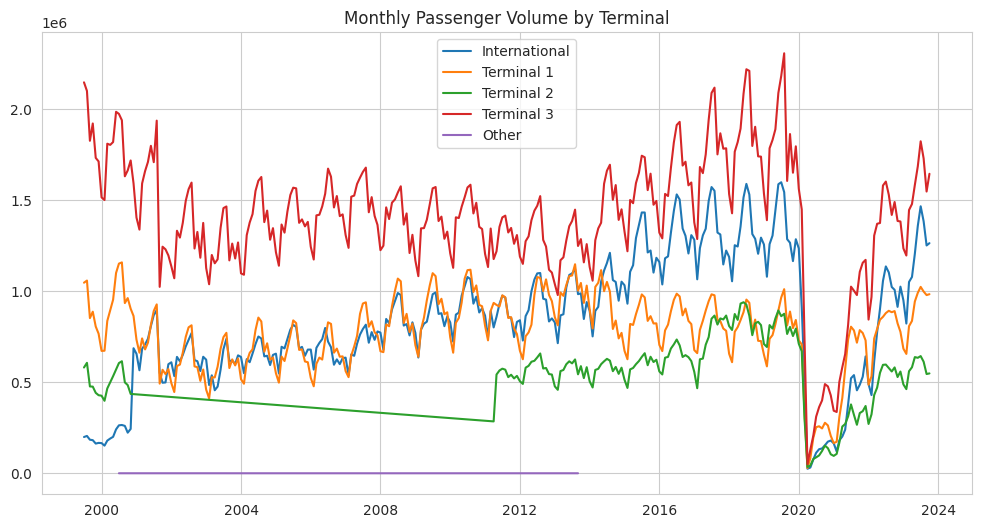

In [234]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

for terminal in monthly_terminal['Terminal'].unique():
    subset = monthly_terminal[monthly_terminal['Terminal'] == terminal]
    plt.plot(subset['Activity Period Start Date'],
             subset['Passenger Count'],
             label=terminal)

plt.legend()
plt.title("Monthly Passenger Volume by Terminal")
plt.show()

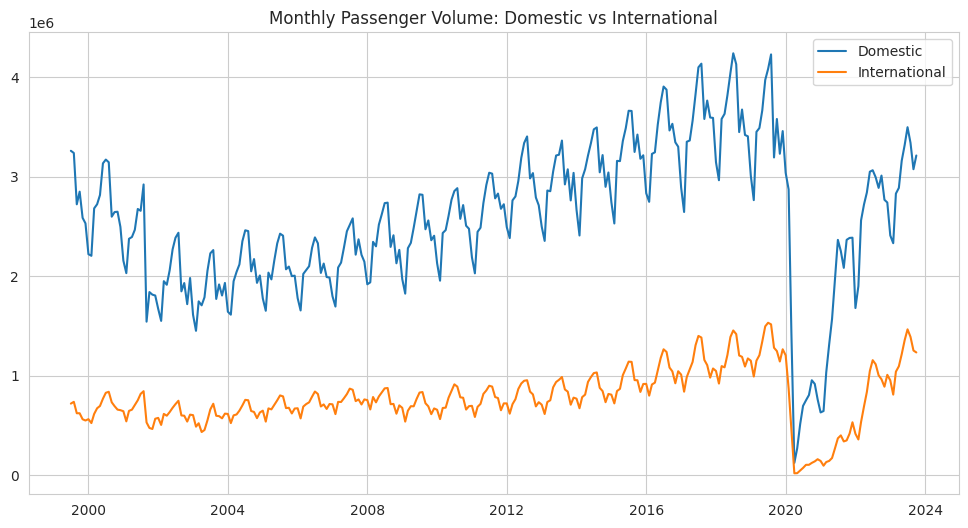

In [235]:
plt.figure(figsize=(12,6))

for geo in monthly_geo['GEO Summary'].unique():
    subset = monthly_geo[monthly_geo['GEO Summary'] == geo]
    plt.plot(subset['Activity Period Start Date'],
             subset['Passenger Count'],
             label=geo)

plt.legend()
plt.title("Monthly Passenger Volume: Domestic vs International")
plt.show()

Domestic traffic represents ~3.3× international volume structurally (~753M vs ~227M cumulative passengers).

However, international traffic exhibits:



*   Higher amplitude volatility

*   More severe COVID contraction

*   Slower recovery trajectory

Because premium lounge utilization skews toward international travelers, lounge demand elasticity may be materially higher than aggregate passenger elasticity.

This divergence reinforces the need for regime-aware modeling rather than extrapolating total passenger growth linearly.

In [236]:
df['Month_Num'] = df['Activity Period Start Date'].dt.month

monthly_seasonality = (
    df.groupby('Month_Num')['Passenger Count']
    .mean()
    .reset_index()
)

monthly_seasonality

,Month_Num,Passenger Count
0,1,24730.629954
1,2,23210.657031
2,3,27183.747965
3,4,27385.819484
4,5,28740.450157
5,6,30415.922972
6,7,31664.512945
7,8,31680.732558
8,9,27311.618985
9,10,28463.966831


Passenger volume exhibits persistent 12-month seasonality, with July–August peaks approximately 25–30% above February trough levels.

Because congestion effects are nonlinear near capacity limits, peak-month dynamics, not annual averages, determine expansion timing.

Therefore, capacity modeling must be calibrated to peak seasonal load rather than mean monthly demand.

In [237]:
terminal_geo = (
    df.groupby(['Terminal', 'GEO Summary'])['Passenger Count']
    .sum()
    .reset_index()
)

terminal_geo

,Terminal,GEO Summary,Passenger Count
0,International,Domestic,45676554
1,International,International,198978083
2,Other,Domestic,352
3,Other,International,4
4,Terminal 1,Domestic,222801529
5,Terminal 1,International,4781221
6,Terminal 2,Domestic,85392079
7,Terminal 2,International,9430157
8,Terminal 3,Domestic,399536569
9,Terminal 3,International,14122028


In [238]:
terminal_price = (
    df.groupby(['Terminal', 'Price Category Code'])['Passenger Count']
    .sum()
    .reset_index()
)

terminal_price

,Terminal,Price Category Code,Passenger Count
0,International,Low Fare,26405594
1,International,Other,218249043
2,Other,Other,356
3,Terminal 1,Low Fare,73073307
4,Terminal 1,Other,154509443
5,Terminal 2,Low Fare,29850546
6,Terminal 2,Other,64971690
7,Terminal 3,Low Fare,5977198
8,Terminal 3,Other,407681399


In [239]:
intl_terminal = monthly_terminal[
    monthly_terminal['Terminal'] == 'International'
].copy()

intl_terminal.head()

,Activity Period Start Date,Terminal,Passenger Count
0,1999-07-01,International,199340
4,1999-08-01,International,205182
8,1999-09-01,International,184435
12,1999-10-01,International,181993
16,1999-11-01,International,163274


In [240]:
intl_monthly = intl_terminal.groupby('Activity Period Start Date')['Passenger Count'].sum().reset_index()

intl_monthly = intl_monthly.sort_values('Activity Period Start Date')
intl_monthly.set_index('Activity Period Start Date', inplace=True)

intl_monthly.head()

,Passenger Count
Activity Period Start Date,
1999-07-01,199340
1999-08-01,205182
1999-09-01,184435
1999-10-01,181993
1999-11-01,163274


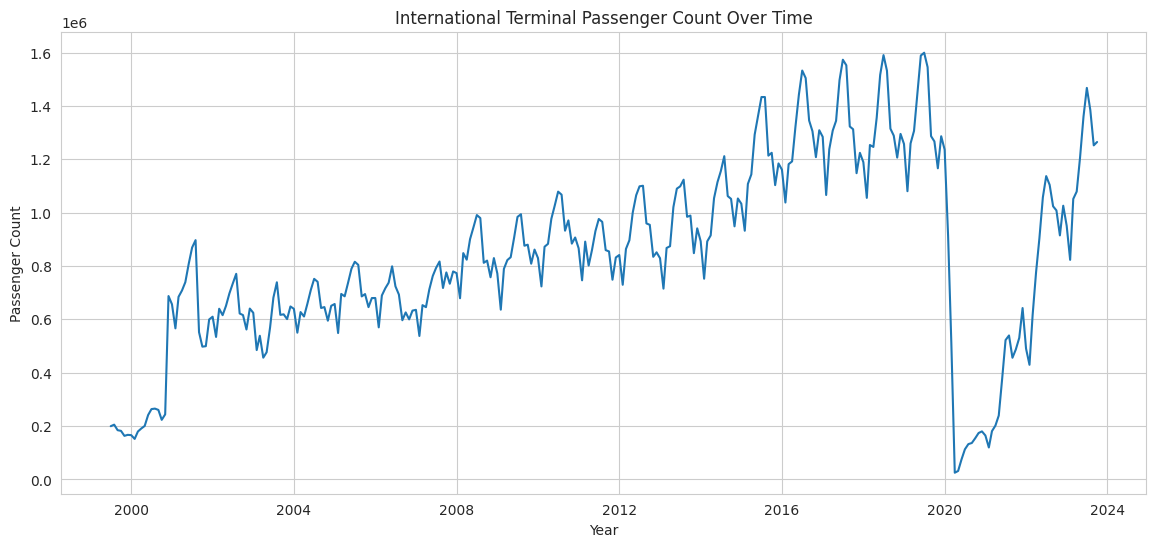

In [241]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(intl_monthly.index, intl_monthly['Passenger Count'])
plt.title("International Terminal Passenger Count Over Time")
plt.xlabel("Year")
plt.ylabel("Passenger Count")
plt.grid(True)
plt.show()

The International Terminal exhibits three distinct regimes:

1. Structural Expansion (2003–2019)
Sustained secular growth with stable seasonal amplitude, indicating increasing long-haul demand and international connectivity expansion.

2. Structural Shock (2020)
Near-complete collapse in international throughput, representing a regime discontinuity rather than cyclical deviation.

3. Recovery Regime (2021–Present)
Nonlinear rebound with elevated variance and incomplete convergence to 2018–19 peak levels.

Because premium lounge utilization skews toward international travelers, lounge capacity stress is structurally tied to this terminal’s regime dynamics rather than airport-wide averages.

International Terminal exhibits long-term upward trend, strong seasonality, and a structural break in 2020.
Forecasting must account for regime change rather than assume full historical continuity.

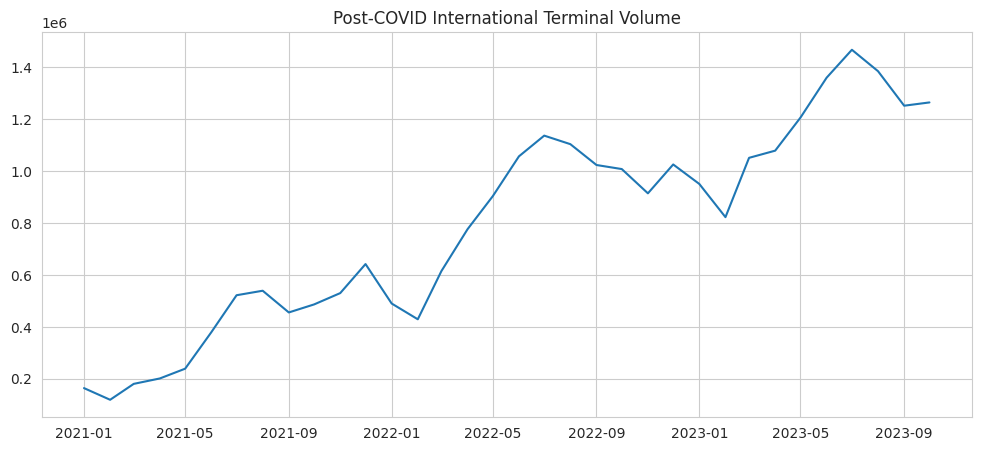

,Passenger Count
count,3.400000e+01
mean,7.879184e+05
std,3.936006e+05
min,1.196320e+05
25%,4.877460e+05
50%,8.634325e+05
75%,1.073562e+06
max,1.467528e+06


In [242]:
# Extract post-COVID period (Jan 2021 onward)
post_covid = intl_monthly.loc['2021-01-01':].copy()

plt.figure(figsize=(12,5))
plt.plot(post_covid.index, post_covid['Passenger Count'])
plt.title("Post-COVID International Terminal Volume")
plt.grid(True)
plt.show()

post_covid.describe()

The post-2021 recovery regime exhibits:

1. Positive slope exceeding late-cycle 2017–19 growth rates

2. Re-emergent but amplitude-unstable seasonality

3. Elevated volatility relative to pre-2020 variance

4. With only ~34 months of observations, parameter estimation uncertainty remains high.

Importantly, international volume has not yet clearly plateaued, implying that lounge congestion risk may accelerate over the next expansion cycle rather than stabilize at current levels.

Post-COVID period shows re-emergence of seasonality with elevated volatility and a new level regime.
Forecasting will focus on stabilized recovery regime rather than full historical series.

In [243]:
# Pre-COVID period (up to Dec 2019)
pre_covid = intl_monthly.loc[:'2019-12-01'].copy()

pre_covid['Month'] = pre_covid.index.month

seasonality_pre = (
    pre_covid.groupby('Month')['Passenger Count']
    .mean()
    .reset_index()
)

seasonality_pre

,Month,Passenger Count
0,1,819921.950000
1,2,704835.350000
2,3,838559.900000
3,4,842068.500000
4,5,915792.550000
5,6,993359.500000
6,7,997298.238095
7,8,997171.666667
8,9,849851.047619
9,10,847505.238095


1. Strong and stable seasonality.
2. July/August peak (~995k).
3. February rough (~704k).
4. Peak-to-trough ratio ≈ 1.41x.

2015–2019 provides five pre-shock seasonal cycles with stable amplitude and trend slope.
Monthly indices from this window are treated as structural seasonal shape parameters, decoupled from post-2020 level shifts.

In [244]:
# Compute 2018-2019 average monthly baseline
baseline = pre_covid.loc['2018-01-01':'2019-12-01']['Passenger Count'].mean()

# Compute post-COVID monthly ratio to baseline
post_covid_ratio = post_covid.copy()
post_covid_ratio['Recovery_Ratio'] = post_covid_ratio['Passenger Count'] / baseline

post_covid_ratio[['Passenger Count', 'Recovery_Ratio']].tail(12)

,Passenger Count,Recovery_Ratio
Activity Period Start Date,,
2022-11-01,914675,0.687438
2022-12-01,1025861,0.771001
2023-01-01,950739,0.714542
2023-02-01,822954,0.618504
2023-03-01,1051392,0.790190
2023-04-01,1079037,0.810967
2023-05-01,1206447,0.906724
2023-06-01,1359961,1.022099
2023-07-01,1467528,1.102943


Recovery ratio exceeds 1.0 by mid-2023, indicating full normalization relative to 2018–19 average levels.
Peak month (July 2023) reaches ~110% of baseline mean, implying overshoot rather than simple reversion.

Subsequent stabilization around 0.94–0.95 suggests convergence toward a new equilibrium band rather than continued acceleration.

International throughput has transitioned from recovery phase to level-shift regime, where dynamics reflect new demand equilibrium rather than catch-up growth.

In [245]:
# Extract 2023 only
data_2023 = post_covid.loc['2023-01-01':'2023-12-01'].copy()

peak_2023 = data_2023['Passenger Count'].max()
trough_2023 = data_2023['Passenger Count'].min()

peak_to_trough_2023 = peak_2023 / trough_2023

peak_to_trough_2023

1.78324426395643

Post-COVID peak-to-trough amplitude (1.78x) materially exceeds pre-COVID amplitude (1.41x), indicating volatility expansion in the new regime.
Hybrid specification preserves historical seasonal structure while re-anchoring level and variance to post-2023 equilibrium conditions.

In [246]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(post_covid['Passenger Count'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.11963508699632
p-value: 0.7071784830146857


ADF test fails to reject unit root (p > 0.05), confirming persistence in post-COVID levels.
Trend component must be modeled explicitly (deterministic trend or decomposition-based approach) rather than assuming covariance stationarity.

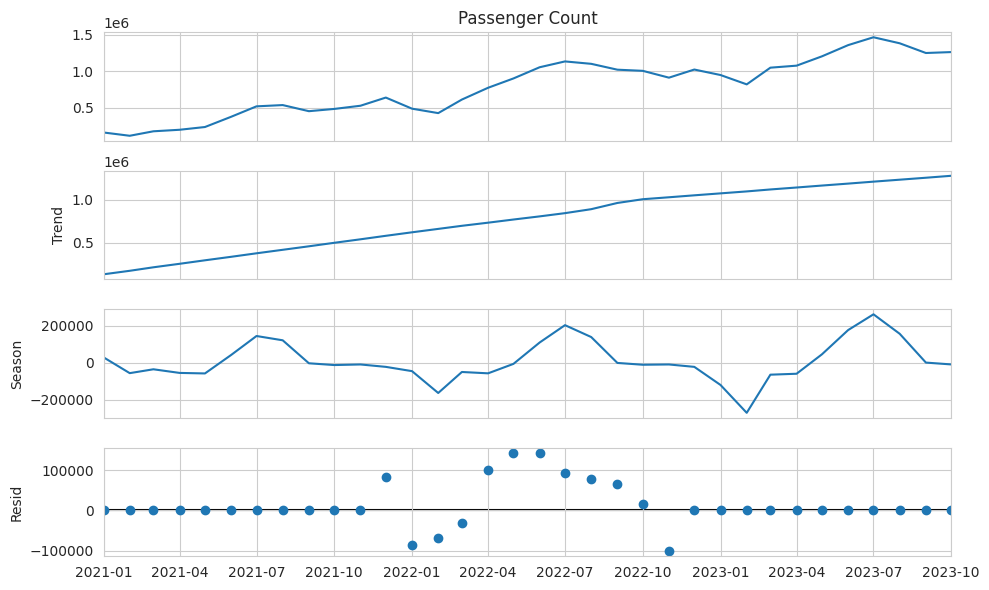

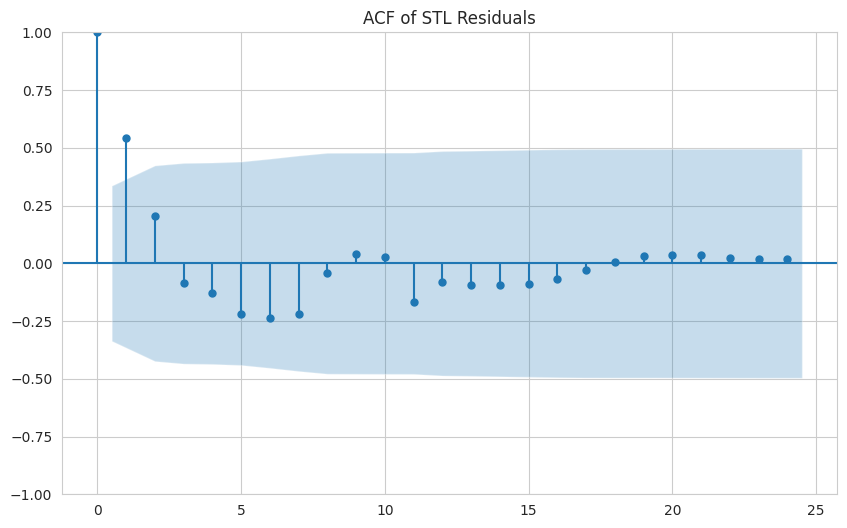

In [247]:
from statsmodels.tsa.seasonal import STL

# STL Decomposition (robust trend + seasonality extraction)
stl = STL(post_covid['Passenger Count'], period=12, robust=True)
res = stl.fit()

fig = res.plot()
plt.show()

# Residual autocorrelation check
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(res.resid, lags=24)
plt.title("ACF of STL Residuals")
plt.show()

Raw level series is non-stationary, necessitating structural decomposition.
STL cleanly separates monotonic trend and 12-month seasonal structure, leaving residuals with limited serial correlation.

Low residual autocorrelation supports hybrid reconstruction (trend + seasonal + stochastic noise) over naïve AR extrapolation.

Post-COVID regime exhibits re-stabilized seasonality with reduced trend slope, indicating transition from recovery acceleration to level consolidation phase.

In [248]:
import numpy as np

# Add time index
post_covid_trend = post_covid.copy()
post_covid_trend['t'] = np.arange(len(post_covid_trend))

# Fit simple linear regression
coeffs = np.polyfit(post_covid_trend['t'],
                    post_covid_trend['Passenger Count'],
                    1)

slope = coeffs[0]
intercept = coeffs[1]

slope

np.float64(37294.242475171886)

STL trend component informs structural regime diagnostics; projection layer intentionally re-anchors level using stabilized 2023 mean rather than extrapolated trend continuation.

# Modeling Approach

### Rationale for Hybrid Projection Approach

The 2024 projection intentionally uses a structural hybrid model:

Seasonal Index (2015–2019 stable regime) × 2023 stabilized level.

A fully parameterized SARIMA, Holt-Winters, or Prophet model was intentionally not deployed for the following reasons:

• Post-COVID regime contains ~36 observations — insufficient for stable multi-parameter seasonal estimation.

• Recovery phase (2021–2022) exhibits nonstationary transition dynamics.

• Objective is capital sensitivity analysis and interpretability, not macroeconomic precision.

Framework prioritizes regime interpretability, capital sensitivity transparency, and congestion-threshold clarity over automated statistical fit optimization.

Forecasting Structure:
• 2015–2019 window used to estimate stationary seasonal shape coefficients.

• 2023 mean level treated as post-recovery equilibrium anchor.

• Baseline projection = Seasonal Index × 2023 Regime Mean.

• Deterministic growth overlays tested: –2%, 0%, +3%, +6%.

• 2022→2023 backtest used to validate regime anchoring decision rather than optimize predictive error.


## Demand Funnel Structure:
Total Terminal Volume
→ Non–Low-Fare Share

→ Premium Cabin Share (Synthetic Assumption)

→ Premium Card Penetration

→ Lounge Selection Preference

→ Peak Hour Concentration

→ Peak Occupancy Simulation

In [249]:
# Use 2022 as training, 2023 as validation
train = post_covid.loc['2022-01-01':'2022-12-01']
test = post_covid.loc['2023-01-01':'2023-10-01']

len(train), len(test)

(12, 10)

In [250]:
train = post_covid.loc['2021-01-01':'2022-12-01']
test = post_covid.loc['2023-01-01':'2023-10-01']

len(train), len(test)

(24, 10)

In [251]:
seasonal_base = intl_monthly.loc['2015-01-01':'2019-12-01'].copy()
len(seasonal_base)

60

In [252]:
seasonal_base = intl_monthly.loc['2015-01-01':'2019-12-01'].copy()
seasonal_base['Month'] = seasonal_base.index.month

seasonal_avg = seasonal_base.groupby('Month')['Passenger Count'].mean()

# Convert to seasonal index (relative to mean)
seasonal_index = seasonal_avg / seasonal_avg.mean()

seasonal_index

,Passenger Count
Month,
1,0.913794
2,0.797605
3,0.931485
4,0.955518
5,1.042691
6,1.142529
7,1.191999
8,1.167041
9,0.999866


Seasonal indices normalized to unity mean preserve proportional intra-year structure.
Peak multiplier (July ≈ 1.19) and trough multiplier (February ≈ 0.80) define structural seasonal amplitude embedded into 2024 regime projection.


In [253]:
avg_2023 = data_2023['Passenger Count'].mean()
avg_2023

np.float64(1184000.5)

In [254]:
data_2023['Month'] = data_2023.index.month

season_2023_avg = data_2023.groupby('Month')['Passenger Count'].mean()
season_2023_avg

,Passenger Count
Month,
1,950739.0
2,822954.0
3,1051392.0
4,1079037.0
5,1206447.0
6,1359961.0
7,1467528.0
8,1385049.0
9,1252147.0


In [255]:
seasonal_index

,Passenger Count
Month,
1,0.913794
2,0.797605
3,0.931485
4,0.955518
5,1.042691
6,1.142529
7,1.191999
8,1.167041
9,0.999866


Historical seasonal geometry is preserved while absolute level shifts upward relative to pre-2020 baseline.
Post-COVID amplitude expansion suggests higher volatility band.
Trend slope compression in late-2023 indicates emerging equilibrium formation.

In [256]:
forecast_2024 = seasonal_index * avg_2023
forecast_2024

,Passenger Count
Month,
1,1.081933e+06
2,9.443645e+05
3,1.102879e+06
4,1.131333e+06
5,1.234547e+06
6,1.352755e+06
7,1.411328e+06
8,1.381777e+06
9,1.183841e+06


In [257]:
# Use 2022 average as level
avg_2022 = post_covid.loc['2022-01-01':'2022-12-01']['Passenger Count'].mean()

# Project 2023 using hybrid model
forecast_2023_from_2022 = seasonal_index * avg_2022

# Align months
actual_2023 = data_2023['Passenger Count'].values[:10]
forecast_2023_vals = forecast_2023_from_2022.values[:10]

# Compute MAPE
mape_2023 = np.mean(np.abs((actual_2023 - forecast_2023_vals) / actual_2023))

print(f"Hybrid Backtest MAPE (2023 projection from 2022 level): {mape_2023:.2%}")

Hybrid Backtest MAPE (2023 projection from 2022 level): 24.50%


Hybrid Backtest MAPE (2023 projection from 2022 level): 24.50%.
Elevated error confirms 2022 remained within transition regime with unstable level dynamics.
Result supports regime re-anchoring to 2023 stabilized mean rather than extrapolating transitional recovery slope.
Backtest informs structural baseline selection, not statistical model rejection.

In [258]:
# Annualized 2023 (using Jan–Oct scaled)
total_2023_actual = data_2023['Passenger Count'].sum() * (12/10)

# 2024 baseline total
total_2024_baseline = forecast_2024.sum()

total_2023_actual, total_2024_baseline

(np.float64(14208006.0), np.float64(14208005.999999998))

2024 baseline reflects stabilized 2023 equilibrium level combined with historically validated seasonal structure.
Projection is structural and regime-consistent, designed for capacity stress testing rather than macroeconomic forecasting.

In [259]:
forecast_2024_flat = forecast_2024
forecast_2024_3 = forecast_2024 * 1.03
forecast_2024_6 = forecast_2024 * 1.06
forecast_2024_neg2 = forecast_2024 * 0.98

In [260]:
forecast_2024_flat

,Passenger Count
Month,
1,1.081933e+06
2,9.443645e+05
3,1.102879e+06
4,1.131333e+06
5,1.234547e+06
6,1.352755e+06
7,1.411328e+06
8,1.381777e+06
9,1.183841e+06


In [261]:

forecast_2024_3

,Passenger Count
Month,
1,1.114391e+06
2,9.726954e+05
3,1.135965e+06
4,1.165273e+06
5,1.271584e+06
6,1.393338e+06
7,1.453668e+06
8,1.423231e+06
9,1.219357e+06


In [262]:

forecast_2024_6

,Passenger Count
Month,
1,1.146849e+06
2,1.001026e+06
3,1.169051e+06
4,1.199213e+06
5,1.308620e+06
6,1.433920e+06
7,1.496007e+06
8,1.464684e+06
9,1.254872e+06


In [263]:

forecast_2024_neg2

,Passenger Count
Month,
1,1.060294e+06
2,9.254772e+05
3,1.080821e+06
4,1.108707e+06
5,1.209856e+06
6,1.325700e+06
7,1.383101e+06
8,1.354142e+06
9,1.160165e+06


In [264]:
intl_price = terminal_price[terminal_price['Terminal'] == 'International']
intl_price

premium_proxy_share = intl_price.loc[
    intl_price['Price Category Code'] == 'Other',
    'Passenger Count'
].values[0] / intl_price['Passenger Count'].sum()

premium_proxy_share

np.float64(0.8920699222226472)

Non–low-fare share (~89%) serves as an upper bound for premium-eligible traffic.
Premium cabin share will be explicitly stress-tested due to structural uncertainty.

In [265]:
daily_avg = 437.4769684371612

peak_share = 0.65
peak_hours = 7
peak_dwell = 2.5

peak_daily_visits = daily_avg * peak_share
peak_hour_arrivals = peak_daily_visits / peak_hours
peak_occupancy_estimate = peak_hour_arrivals * peak_dwell

peak_hour_arrivals, peak_occupancy_estimate

(40.622861354879255, 101.55715338719814)

In [266]:
# Sensitivity: Premium cabin share assumptions
premium_share_scenarios = [0.15, 0.18, 0.22]

capacity_results = {}

for p_share in premium_share_scenarios:
    annual_visits_sens = forecast_2024_3.sum() * premium_proxy_share * p_share * 0.10 * 0.70
    july_monthly_sens = annual_visits_sens * (seasonal_index.loc[7] / 12)
    july_daily_sens = july_monthly_sens / 31
    peak_arrivals_sens = (july_daily_sens * peak_share) / peak_hours

    np.random.seed(42)
    sim_arrivals_sens = np.random.normal(peak_arrivals_sens, peak_arrivals_sens*0.15, 1000)
    sim_occ_sens = sim_arrivals_sens * peak_dwell

    overflow_rate_sens = np.mean(sim_occ_sens > 130)
    capacity_results[p_share] = overflow_rate_sens

capacity_results

{0.15: np.float64(0.037), 0.18: np.float64(0.33), 0.22: np.float64(0.822)}

Capacity risk is materially more sensitive to premium penetration assumptions than to passenger growth alone.
Premium mix is the dominant structural risk driver in lounge sizing.

In [267]:
annual_passengers = forecast_2024.sum()

non_low_fare = annual_passengers * premium_proxy_share

premium_12 = non_low_fare * 0.12
premium_18 = non_low_fare * 0.18
premium_25 = non_low_fare * 0.25

premium_12, premium_18, premium_25

(np.float64(1520944.1768830684),
 np.float64(2281416.2653246024),
 np.float64(3168633.701839726))

In [268]:
100_000 / annual_passengers

np.float64(0.007038285316039423)

In [269]:
effective_share = premium_proxy_share * 0.18 * 0.10 * 0.70
effective_share

np.float64(0.011240081020005356)

Base-case effective lounge capture ≈ 1.1% of total terminal traffic.
This magnitude is consistent with premium access dynamics and validates order-of-magnitude reasonableness.

In [270]:
annual_visits = annual_passengers * effective_share
daily_avg = annual_visits / 365
daily_avg

np.float64(437.5318865006088)

Peak steady-state occupancy is approximated using Little’s Law:

Occupancy ≈ Arrival Rate × Average Dwell Time

This assumes stable arrival intensity within defined peak windows and does not model flight-bank wave compression.


# Core Structural Assumptions

## Passenger Forecasting:
• 2024 baseline anchored to 2023 stabilized regime.

• Seasonal shape derived from 2015–2019 stable period.

• Projection assumes no macro shock or structural airline disruption.

## Premium Lounge Funnel:
• Non–Low-Fare Share ≈ 89% (observed in dataset).

• Premium Cabin Share (synthetic stress-tested range): 15%–22%.

• Premium Card Penetration: 10%.

• Lounge Preference Rate: 70%.

• Effective Base Capture ≈ 1.1% of total terminal traffic.

## Operational Structure:
• Operating Window: 16 hours/day.

• Peak Window: 65% of daily visits in 7 hours (stress-tested).

• Peak Dwell Time: 2.5 hours (sensitivity tested 2.0–3.0).

• Arrival Dispersion: ±15% baseline (tested at 25%).

## Congestion Definition:
• Overflow = Peak simulated occupancy > seating capacity.

• 20% overflow probability is used as a planning threshold for capital trigger discussion.

In practice, this threshold would be aligned to customer experience tolerance, NPS impact, or service-level policy targets.

## Synthetic Data Considerations

The synthetic credit card layer is not intended to estimate true portfolio penetration.

Its purpose is to identify sensitivity dominance — i.e., which structural assumptions most materially influence nonlinear congestion risk.

Congestion risk exhibits convex behavior as system utilization approaches capacity.

While occupancy scales linearly with demand, overflow probability increases nonlinearly near capacity thresholds.

The following components are synthetic and explicitly stress-tested:

• Premium cabin share.

• Card penetration rate.

• Lounge preference rate.

• Peak concentration ratio.

• Arrival dispersion.

• Dwell time assumption.

These parameters materially influence capacity sizing and are evaluated
via sensitivity testing to identify dominant structural risk drivers.




# Model Limitations

This framework is intentionally structural and strategic in scope. It does not explicitly model airline bank scheduling effects, passenger arrival micro-timing, queue abandonment dynamics, or real-time access throttling mechanisms. It also does not attempt to provide operational SLA guarantees or function as a macroeconomic forecasting engine.

The objective is not short-term operational optimization, but strategic capital planning under demand uncertainty. The model is designed to identify capacity stress thresholds, evaluate premium portfolio growth sensitivity, and inform expansion timing decisions within a regime-aware demand structure.

Key Insight Objective: To determine how small increases in premium portfolio growth or structural mix
assumptions nonlinearly amplify peak-hour congestion risk and influence required
lounge seating capacity.


In [271]:
capacities = [80, 100, 120, 150]

for cap in capacities:
    overload = peak_occupancy_estimate - cap
    print(f"Capacity {cap}: Overload = {overload:.2f}")


Capacity 80: Overload = 21.56
Capacity 100: Overload = 1.56
Capacity 120: Overload = -18.44
Capacity 150: Overload = -48.44


In [272]:
monthly_base_lounge = annual_visits / 12
july_lounge_monthly = monthly_base_lounge * seasonal_index.loc[7]
july_lounge_daily = july_lounge_monthly / 31

peak_daily_visits_july = july_lounge_daily * peak_share
peak_hour_arrivals_july = peak_daily_visits_july / peak_hours
peak_occupancy_july = peak_hour_arrivals_july * peak_dwell

july_lounge_daily, peak_hour_arrivals_july, peak_occupancy_july

(np.float64(511.723802763532),
 np.float64(47.51721025661369),
 np.float64(118.79302564153421))

In [273]:
for dwell in [2.0, 2.5, 3.0]:
    peak_occ = peak_hour_arrivals_july * dwell
    print(f"Dwell {dwell} hrs → Peak occupancy = {peak_occ:.1f}")

Dwell 2.0 hrs → Peak occupancy = 95.0
Dwell 2.5 hrs → Peak occupancy = 118.8
Dwell 3.0 hrs → Peak occupancy = 142.6


Congestion risk is highly sensitive to dwell time variability.
Operational delays materially amplify peak occupancy even without volume growth.

In [274]:
print("Overflow Sensitivity to Premium Cabin Share (130 Seats, +3% Growth)\n")

for p_share in sorted(capacity_results.keys()):
    overflow = capacity_results[p_share]
    print(f"Premium Share: {p_share*100:.0f}%  |  Overflow Rate: {overflow:.1%}")

Overflow Sensitivity to Premium Cabin Share (130 Seats, +3% Growth)

Premium Share: 15%  |  Overflow Rate: 3.7%
Premium Share: 18%  |  Overflow Rate: 33.0%
Premium Share: 22%  |  Overflow Rate: 82.2%


In [275]:
import pandas as pd

sensitivity_df = pd.DataFrame({
    "Premium Share (%)": [k*100 for k in capacity_results.keys()],
    "Overflow Rate": [v for v in capacity_results.values()]
})

sensitivity_df.sort_values("Premium Share (%)")

,Premium Share (%),Overflow Rate
0,15.0,0.037
1,18.0,0.330
2,22.0,0.822


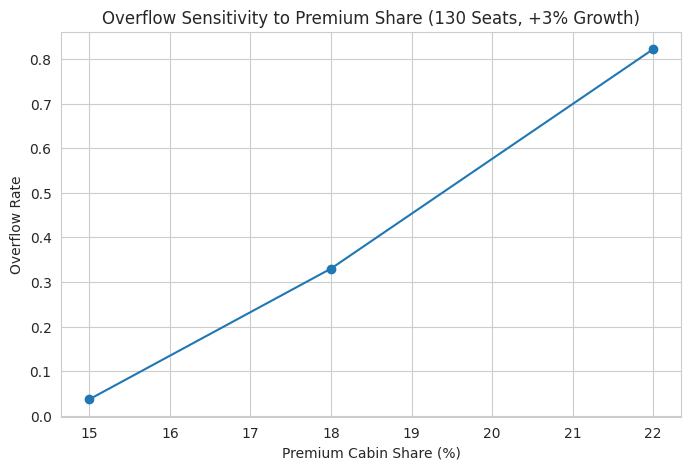

In [276]:
plt.figure(figsize=(8,5))
plt.plot([k*100 for k in capacity_results.keys()],
         list(capacity_results.values()),
         marker='o')
plt.xlabel("Premium Cabin Share (%)")
plt.ylabel("Overflow Rate")
plt.title("Overflow Sensitivity to Premium Share (130 Seats, +3% Growth)")
plt.grid(True)
plt.show()

## Capital Allocation Tradeoff: Lost Revenue vs. Expansion Cost

This section converts congestion overflow risk into economic terms.
We compare:

1. Expected annual revenue lost due to denied lounge access
2. Annualized capital cost of seat expansion

Objective:
Identify the seating configuration that maximizes net economic benefit
under defined portfolio and cost assumptions.


In [277]:
annual_passengers_forecast = 15_000_000
premium_proxy_share = 0.70
premium_cabin_share = 0.20
card_penetration = 0.10
lounge_usage_rate = 0.75

peak_share = 0.70
peak_hours = 6
peak_dwell = 2.5

In [278]:
# --- Demand Funnel ---
non_low = annual_passengers_forecast * premium_proxy_share
premium_pool = non_low * premium_cabin_share
annual_visits = premium_pool * card_penetration * lounge_usage_rate

# --- Convert to Peak Hour ---
daily_visits = annual_visits / 365
peak_daily = daily_visits * peak_share
peak_hour_arrivals = peak_daily / peak_hours

# --- Simulate Peak Occupancy ---
sim_arrivals = np.random.normal(
    peak_hour_arrivals,
    peak_hour_arrivals * 0.15,
    5000
)

sim_occ = sim_arrivals * peak_dwell

print("Mean peak occupancy:", np.mean(sim_occ))
print("95th percentile occupancy:", np.percentile(sim_occ, 95))
print("Max simulated occupancy:", np.max(sim_occ))

Mean peak occupancy: 125.71246179361977
95th percentile occupancy: 156.82970486534353
Max simulated occupancy: 199.9773471120899


In [279]:
capacity = 130

overflow_indicator = sim_occ > capacity
overflow_probability = np.mean(overflow_indicator)

average_excess_when_overflow = np.mean(
    np.where(overflow_indicator, sim_occ - capacity, 0)
)

print("Overflow probability:", overflow_probability)
print("Average excess seats (when averaging across all sims):", average_excess_when_overflow)

Overflow probability: 0.4122
Average excess seats (when averaging across all sims): 5.564858951706938


In [280]:
revenue_per_visit = 75
loss_rate = 0.70
peak_months = 4

# Lost seats per peak hour (expected value across sims)
expected_overflow_per_hour = average_excess_when_overflow

# Convert to lost visits in one peak month
lost_visits_peak_month = (
    expected_overflow_per_hour
    * peak_hours
    * 31
    * loss_rate
)

annual_lost_visits = lost_visits_peak_month * peak_months

annual_lost_revenue_130 = annual_lost_visits * revenue_per_visit

print("Annual lost revenue at 130 seats:", annual_lost_revenue_130)

Annual lost revenue at 130 seats: 217363.39065367304


In [281]:
capex_per_seat = 45000
seat_life_years = 7
discount_rate = 0.10

annuity_factor = (
    discount_rate * (1 + discount_rate) ** seat_life_years
) / ((1 + discount_rate) ** seat_life_years - 1)

annual_seat_cost = capex_per_seat * annuity_factor

print("Annualized cost per seat:", annual_seat_cost)

Annualized cost per seat: 9243.247486526801


In [282]:
capacity = 140

overflow_indicator = sim_occ > capacity
overflow_probability = np.mean(overflow_indicator)

average_excess = np.mean(
    np.where(overflow_indicator, sim_occ - capacity, 0)
)

# Convert to annual lost revenue
lost_visits_peak_month = (
    average_excess
    * peak_hours
    * 31
    * loss_rate
)

annual_lost_visits = lost_visits_peak_month * peak_months
annual_lost_revenue_140 = annual_lost_visits * revenue_per_visit

# Expansion cost from 130 → 140
seats_added = 140 - 130
expansion_cost_140 = seats_added * annual_seat_cost

net_benefit_140 = annual_lost_revenue_130 - annual_lost_revenue_140 - expansion_cost_140

print("Overflow probability (140 seats):", overflow_probability)
print("Annual lost revenue (140 seats):", annual_lost_revenue_140)
print("Expansion annual cost (130→140):", expansion_cost_140)
print("Net economic benefit vs 130:", net_benefit_140)

Overflow probability (140 seats): 0.2202
Annual lost revenue (140 seats): 95072.97360144119
Expansion annual cost (130→140): 92432.47486526801
Net economic benefit vs 130: 29857.94218696383


In [283]:
capacity = 150

overflow_indicator = sim_occ > capacity
overflow_probability = np.mean(overflow_indicator)

average_excess = np.mean(
    np.where(overflow_indicator, sim_occ - capacity, 0)
)

lost_visits_peak_month = (
    average_excess
    * peak_hours
    * 31
    * loss_rate
)

annual_lost_visits = lost_visits_peak_month * peak_months
annual_lost_revenue_150 = annual_lost_visits * revenue_per_visit

# Expansion cost from 130 → 150
seats_added = 150 - 130
expansion_cost_150 = seats_added * annual_seat_cost

net_benefit_150 = annual_lost_revenue_130 - annual_lost_revenue_150 - expansion_cost_150

print("Overflow probability (150 seats):", overflow_probability)
print("Annual lost revenue (150 seats):", annual_lost_revenue_150)
print("Expansion annual cost (130→150):", expansion_cost_150)
print("Net economic benefit vs 130:", net_benefit_150)

Overflow probability (150 seats): 0.0966
Annual lost revenue (150 seats): 34537.4720322668
Expansion annual cost (130→150): 184864.94973053603
Net economic benefit vs 130: -2039.0311091297772


In [284]:
capacity = 155

overflow_indicator = sim_occ > capacity
overflow_probability = np.mean(overflow_indicator)

average_excess = np.mean(
    np.where(overflow_indicator, sim_occ - capacity, 0)
)

lost_visits_peak_month = (
    average_excess
    * peak_hours
    * 31
    * loss_rate
)

annual_lost_visits = lost_visits_peak_month * peak_months
annual_lost_revenue_155 = annual_lost_visits * revenue_per_visit

# Expansion cost from 130 → 155
seats_added = 155 - 130
expansion_cost_155 = seats_added * annual_seat_cost

net_benefit_155 = annual_lost_revenue_130 - annual_lost_revenue_155 - expansion_cost_155

print("Overflow probability (155 seats):", overflow_probability)
print("Annual lost revenue (155 seats):", annual_lost_revenue_155)
print("Expansion annual cost (130→155):", expansion_cost_155)
print("Net economic benefit vs 130:", net_benefit_155)

Overflow probability (155 seats): 0.061
Annual lost revenue (155 seats): 19413.86231215769
Expansion annual cost (130→155): 231081.18716317002
Net economic benefit vs 130: -33131.65882165468


In [285]:
results = []

for capacity in range(130, 171, 5):

    overflow_indicator = sim_occ > capacity
    average_excess = np.mean(
        np.where(overflow_indicator, sim_occ - capacity, 0)
    )

    lost_visits_peak_month = (
        average_excess
        * peak_hours
        * 31
        * loss_rate
    )

    annual_lost_visits = lost_visits_peak_month * peak_months
    annual_lost_revenue = annual_lost_visits * revenue_per_visit

    seats_added = capacity - 130
    expansion_cost = seats_added * annual_seat_cost

    net_benefit = annual_lost_revenue_130 - annual_lost_revenue - expansion_cost

    results.append((capacity, annual_lost_revenue, expansion_cost, net_benefit))

financial_df = pd.DataFrame(
    results,
    columns=["Capacity", "Lost Revenue", "Expansion Cost", "Net Benefit"]
)

financial_df

,Capacity,Lost Revenue,Expansion Cost,Net Benefit
0,130,217363.390654,0.000000,0.000000
1,135,146530.560006,46216.237433,24616.593215
2,140,95072.973601,92432.474865,29857.942187
3,145,58799.079715,138648.712298,19915.598641
4,150,34537.472032,184864.949731,-2039.031109
5,155,19413.862312,231081.187163,-33131.658822
6,160,10333.146411,277297.424596,-70267.180353
7,165,5215.323532,323513.662028,-111365.594907
8,170,2652.034091,369729.899461,-155018.542899


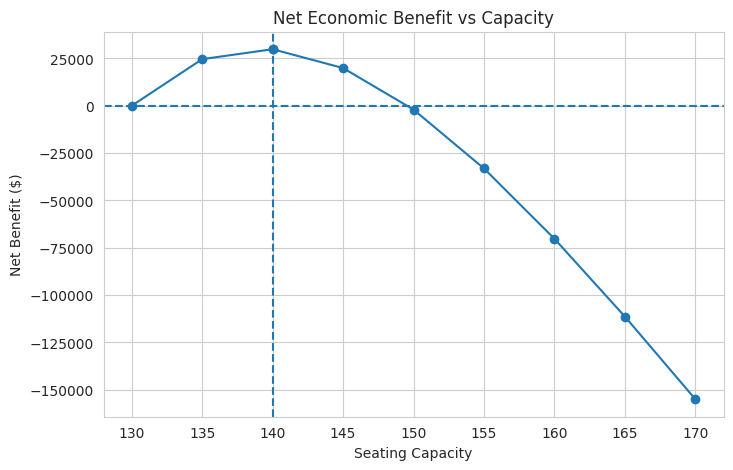

Economic optimum capacity: 140.0
Max net benefit: 29857.94218696383


In [286]:
import matplotlib.pyplot as plt

# Find optimal capacity
optimal_row = financial_df.loc[financial_df["Net Benefit"].idxmax()]
optimal_capacity = optimal_row["Capacity"]
optimal_value = optimal_row["Net Benefit"]

plt.figure(figsize=(8,5))

plt.plot(
    financial_df["Capacity"],
    financial_df["Net Benefit"],
    marker='o'
)

plt.axhline(0, linestyle='--')
plt.axvline(optimal_capacity, linestyle='--')

plt.scatter(optimal_capacity, optimal_value)

plt.title("Net Economic Benefit vs Capacity")
plt.xlabel("Seating Capacity")
plt.ylabel("Net Benefit ($)")
plt.grid(True)

plt.show()

print("Economic optimum capacity:", optimal_capacity)
print("Max net benefit:", optimal_value)

In [287]:
# Compute overflow probability for each capacity
overflow_probs = []

for capacity in financial_df["Capacity"]:
    overflow_indicator = sim_occ > capacity
    overflow_probability = np.mean(overflow_indicator)
    overflow_probs.append(overflow_probability)

financial_df["Overflow Probability"] = overflow_probs

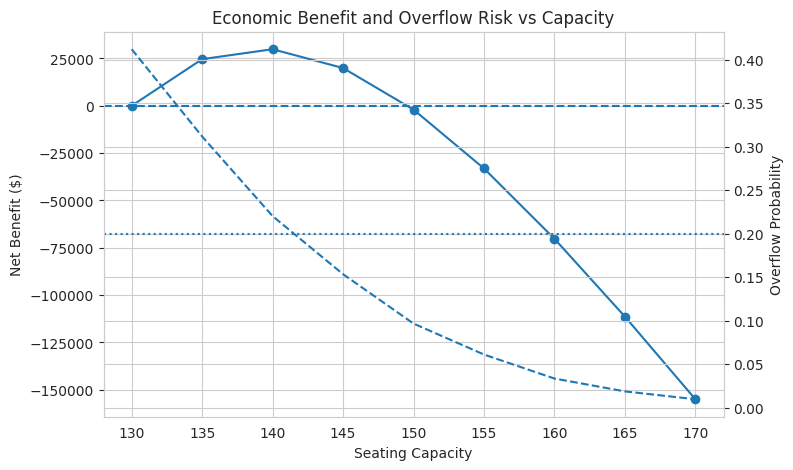

In [288]:
risk_threshold = 0.20

fig, ax1 = plt.subplots(figsize=(8,5))

# Net Benefit (left axis)
ax1.plot(
    financial_df["Capacity"],
    financial_df["Net Benefit"],
    marker='o'
)
ax1.axhline(0, linestyle='--')
ax1.set_xlabel("Seating Capacity")
ax1.set_ylabel("Net Benefit ($)")
ax1.set_title("Economic Benefit and Overflow Risk vs Capacity")
ax1.grid(True)

# Second axis for overflow probability
ax2 = ax1.twinx()
ax2.plot(
    financial_df["Capacity"],
    financial_df["Overflow Probability"],
    linestyle='--'
)
ax2.axhline(risk_threshold, linestyle=':')
ax2.set_ylabel("Overflow Probability")

plt.show()

In [289]:
import numpy as np

np.random.seed(42)

# Assume mean arrivals per peak hour
mean_arrivals = peak_hour_arrivals_july

# Simulate variability ±15%
sim_arrivals = np.random.normal(mean_arrivals, mean_arrivals*0.15, 1000)

# Compute occupancy with 2.5 hr dwell
sim_occupancy = sim_arrivals * 2.5

# % of hours exceeding 100 seats
overflow_rate = np.mean(sim_occupancy > 100)

overflow_rate

np.float64(0.865)

In [290]:
print("\nVariance Sensitivity (July, 130 seats, 0% growth)\n")

for variance in [0.15, 0.25]:
    np.random.seed(42)
    sim_arrivals_var = np.random.normal(peak_hour_arrivals_july,
                                        peak_hour_arrivals_july * variance,
                                        1000)
    sim_occ_var = sim_arrivals_var * peak_dwell
    overflow_var = np.mean(sim_occ_var > 130)

    print(f"Arrival Variance {int(variance*100)}% → Overflow Rate: {overflow_var:.2%}")


Variance Sensitivity (July, 130 seats, 0% growth)

Arrival Variance 15% → Overflow Rate: 26.10%
Arrival Variance 25% → Overflow Rate: 34.30%


Arrival variability modeled using normal distribution with ±15% dispersion.
This provides strategic stress estimation but does not fully capture bursty flight-bank behavior.

Normal dispersion is used as a conservative simplification.

In reality, airline bank structures generate right-skewed and bursty arrival patterns.

This likely increases extreme tail congestion probability relative to the simulated baseline.


In [291]:
for cap in [100, 110, 120, 130, 140]:
    overflow_rate = np.mean(sim_occupancy > cap)
    print(f"Capacity {cap}: Overflow Rate = {overflow_rate:.2%}")

Capacity 100: Overflow Rate = 86.50%
Capacity 110: Overflow Rate = 68.70%
Capacity 120: Overflow Rate = 48.10%
Capacity 130: Overflow Rate = 26.10%
Capacity 140: Overflow Rate = 11.20%


In [292]:
# 1️⃣ Annual passengers under +3% scenario
annual_passengers_3 = forecast_2024_3.sum()

# 2️⃣ Non-low-fare volume
non_low_fare_3 = annual_passengers_3 * premium_proxy_share

# 3️⃣ Premium cabin assumption (18%)
premium_pool_3 = non_low_fare_3 * 0.18

# 4️⃣ Card penetration (10%) × lounge preference (70%)
annual_visits_3 = premium_pool_3 * 0.10 * 0.70

annual_visits_3

np.float64(129074.0513076)

In [293]:
# Monthly July visits under +3%
july_lounge_monthly_3 = annual_visits_3 * (seasonal_index.loc[7] / 12)

# Daily July visits
july_lounge_daily_3 = july_lounge_monthly_3 / 31

# Peak logic
peak_daily_visits_july_3 = july_lounge_daily_3 * peak_share
peak_hour_arrivals_july_3 = peak_daily_visits_july_3 / peak_hours
peak_occupancy_july_3 = peak_hour_arrivals_july_3 * peak_dwell

july_lounge_daily_3, peak_hour_arrivals_july_3, peak_occupancy_july_3

(np.float64(413.5918638230036),
 np.float64(48.25238411268376),
 np.float64(120.63096028170939))

In [294]:
np.random.seed(42)

mean_arrivals_3 = peak_hour_arrivals_july_3
sim_arrivals_3 = np.random.normal(mean_arrivals_3, mean_arrivals_3*0.15, 1000)
sim_occupancy_3 = sim_arrivals_3 * peak_dwell

overflow_130_3 = np.mean(sim_occupancy_3 > 130)

overflow_130_3

np.float64(0.296)

In [295]:
import numpy as np

def compute_overflow(annual_passengers_forecast, capacity=130):
    # Funnel
    non_low = annual_passengers_forecast * premium_proxy_share
    premium_pool = non_low * 0.18
    annual_visits = premium_pool * 0.10 * 0.70

    # July monthly visits (normalized seasonal index)
    july_monthly = annual_visits * (seasonal_index.loc[7] / 12)
    july_daily = july_monthly / 31

    # Peak logic
    peak_daily = july_daily * peak_share
    peak_hour_arrivals = peak_daily / peak_hours

    # Simulate variability
    np.random.seed(42)
    sim_arrivals = np.random.normal(peak_hour_arrivals, peak_hour_arrivals*0.15, 1000)
    sim_occupancy = sim_arrivals * peak_dwell

    overflow_rate = np.mean(sim_occupancy > capacity)

    return overflow_rate

In [296]:
growth_scenarios = {
    "-2%": forecast_2024_neg2.sum(),
    "0%": forecast_2024_flat.sum(),
    "+3%": forecast_2024_3.sum(),
    "+6%": forecast_2024_6.sum()
}

results = {}

for label, annual_pax in growth_scenarios.items():
    results[label] = compute_overflow(annual_pax, capacity=130)

results

{'-2%': np.float64(0.176),
 '0%': np.float64(0.222),
 '+3%': np.float64(0.296),
 '+6%': np.float64(0.373)}

±2% to +6% growth scenarios represent portfolio expansion sensitivity testing rather than precise demand prediction.

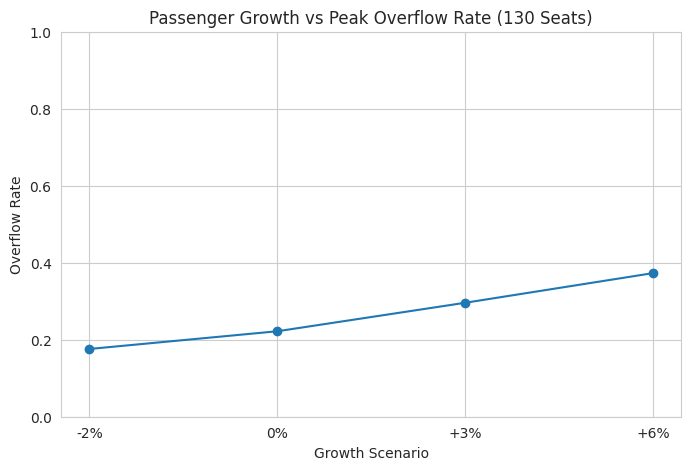

In [297]:
import matplotlib.pyplot as plt

labels = list(results.keys())
overflow_rates = [results[k] for k in labels]

plt.figure(figsize=(8,5))
plt.plot(labels, overflow_rates, marker='o')
plt.title("Passenger Growth vs Peak Overflow Rate (130 Seats)")
plt.ylabel("Overflow Rate")
plt.xlabel("Growth Scenario")
plt.ylim(0,1)
plt.grid(True)
plt.show()

Overflow risk increases nonlinearly with passenger growth.
A 6% demand increase raises congestion risk ~60% relative to baseline at 130-seat capacity.

In [298]:
def overflow_at_capacity(capacity, annual_passengers_forecast):
    non_low = annual_passengers_forecast * premium_proxy_share
    premium_pool = non_low * 0.18
    annual_visits = premium_pool * 0.10 * 0.70

    july_monthly = annual_visits * (seasonal_index.loc[7] / 12)
    july_daily = july_monthly / 31

    peak_daily = july_daily * peak_share
    peak_hour_arrivals = peak_daily / peak_hours

    np.random.seed(42)
    sim_arrivals = np.random.normal(peak_hour_arrivals, peak_hour_arrivals*0.15, 1000)
    sim_occupancy = sim_arrivals * peak_dwell

    return np.mean(sim_occupancy > capacity)

annual_passengers_6 = forecast_2024_6.sum()

for cap in range(130, 181, 5):
    overflow = overflow_at_capacity(cap, annual_passengers_6)
    print(f"Capacity {cap}: Overflow Rate = {overflow:.2%}")


Capacity 130: Overflow Rate = 37.30%
Capacity 135: Overflow Rate = 28.00%
Capacity 140: Overflow Rate = 18.60%
Capacity 145: Overflow Rate = 12.70%
Capacity 150: Overflow Rate = 9.10%
Capacity 155: Overflow Rate = 5.30%
Capacity 160: Overflow Rate = 2.50%
Capacity 165: Overflow Rate = 1.30%
Capacity 170: Overflow Rate = 0.80%
Capacity 175: Overflow Rate = 0.20%
Capacity 180: Overflow Rate = 0.20%


In [299]:
print("\nPeak Concentration Sensitivity (July, 130 seats, 0% growth)\n")

for peak_share_test, peak_hours_test in [(0.65, 7), (0.75, 6)]:

    july_daily_test = july_lounge_daily
    peak_daily_test = july_daily_test * peak_share_test
    peak_hour_arrivals_test = peak_daily_test / peak_hours_test

    np.random.seed(42)
    sim_arrivals_test = np.random.normal(peak_hour_arrivals_test,
                                         peak_hour_arrivals_test * 0.15,
                                         1000)
    sim_occ_test = sim_arrivals_test * peak_dwell
    overflow_test = np.mean(sim_occ_test > 130)

    print(f"{int(peak_share_test*100)}% in {peak_hours_test} hrs → Overflow Rate: {overflow_test:.2%}")


Peak Concentration Sensitivity (July, 130 seats, 0% growth)

65% in 7 hrs → Overflow Rate: 26.10%
75% in 6 hrs → Overflow Rate: 90.10%


Under +6% growth, maintaining ≤20% overflow risk requires ~145 seats.
This represents ~11–12% capacity expansion relative to 130-seat baseline.

### Structural Insights

• This framework identifies dominant structural risk drivers rather than attempting to precisely predict lounge visits.

• Premium mix assumptions influence congestion risk more materially than passenger growth alone.

• Capacity planning errors occur when portfolio growth and operational dwell dynamics interact nonlinearly near utilization thresholds.


This framework is designed for strategic capacity sensitivity analysis.
It does not incorporate airline scheduling waves, queue abandonment behavior, or real-time operational feedback.
Results should inform capital planning discussion rather than operational SLA guarantees.

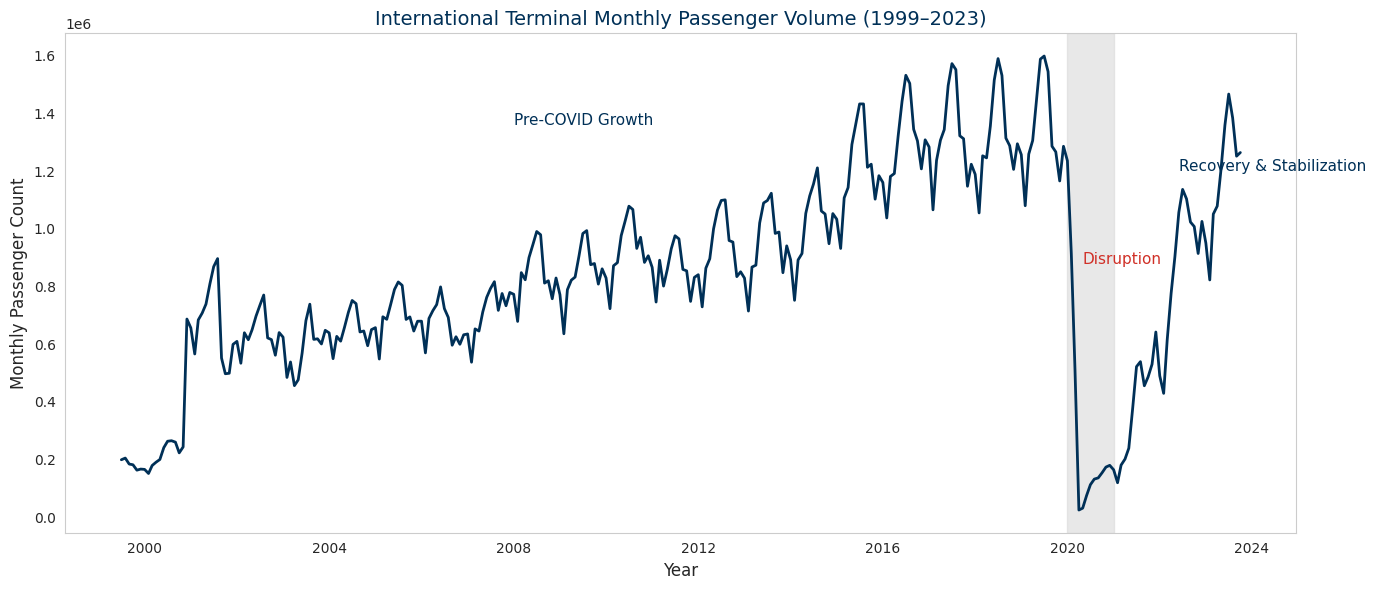

In [300]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure intl_monthly index is datetime
intl_monthly.index = pd.to_datetime(intl_monthly.index)

plt.figure(figsize=(14,6))

# Plot main time series (Capital One Navy)
plt.plot(intl_monthly.index,
         intl_monthly['Passenger Count'],
         color="#003057",
         linewidth=2)

# Shade 2020 disruption period (light grey)
plt.axvspan(pd.to_datetime("2020-01-01"),
            pd.to_datetime("2020-12-31"),
            color="#D9D9D9",
            alpha=0.6)

# Add regime labels
plt.text(pd.to_datetime("2008-01-01"),
         intl_monthly['Passenger Count'].max()*0.85,
         "Pre-COVID Growth",
         fontsize=11,
         color="#003057")

plt.text(pd.to_datetime("2020-05-01"),
         intl_monthly['Passenger Count'].max()*0.55,
         "Disruption",
         fontsize=11,
         color="#D03027")

plt.text(pd.to_datetime("2022-06-01"),
         intl_monthly['Passenger Count'].max()*0.75,
         "Recovery & Stabilization",
         fontsize=11,
         color="#003057")

# Clean styling
plt.title("International Terminal Monthly Passenger Volume (1999–2023)",
          fontsize=14,
          color="#003057")

plt.xlabel("Year", fontsize=12)
plt.ylabel("Monthly Passenger Count", fontsize=12)

plt.grid(False)
plt.tight_layout()
plt.show()


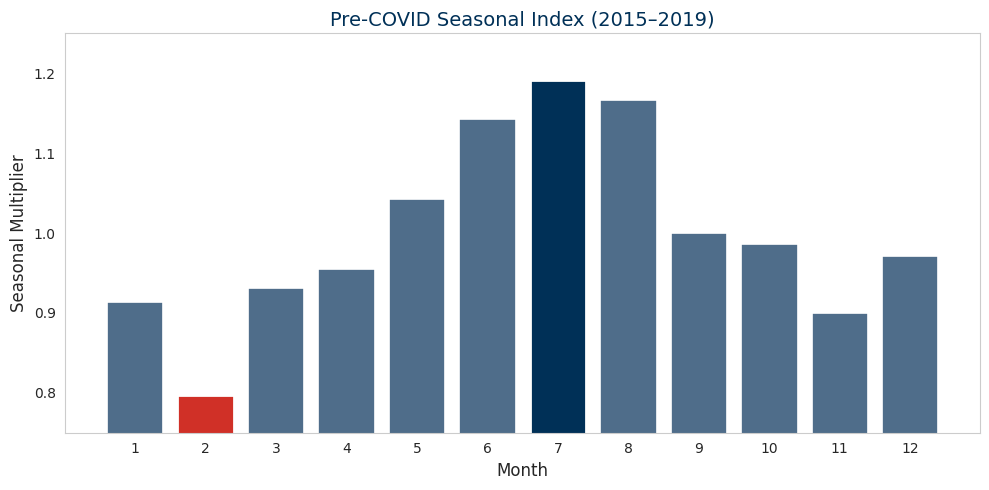

In [301]:
import matplotlib.pyplot as plt
import numpy as np

months = np.arange(1, 13)
values = seasonal_index.values

# Identify max and min indices
max_idx = np.argmax(values)
min_idx = np.argmin(values)

# Define colors
navy = "#003057"
red = "#D03027"
light_navy = "#4F6D8A"   # lighter brand-compatible shade

colors = [light_navy]*12
colors[max_idx] = navy
colors[min_idx] = red

plt.figure(figsize=(10,5))

bars = plt.bar(months,
               values,
               color=colors,
               edgecolor="white",
               linewidth=1.2)


# Add slight vertical emphasis effect (shadow-like depth)
for i, bar in enumerate(bars):
    if i == max_idx or i == min_idx:
        bar.set_linewidth(2)

plt.title("Pre-COVID Seasonal Index (2015–2019)",
          fontsize=14,
          color=navy)

plt.xlabel("Month", fontsize=12)
plt.ylabel("Seasonal Multiplier", fontsize=12)

plt.xticks(months)
plt.ylim(0.75, 1.25)

plt.grid(False)
plt.tight_layout()
plt.show()


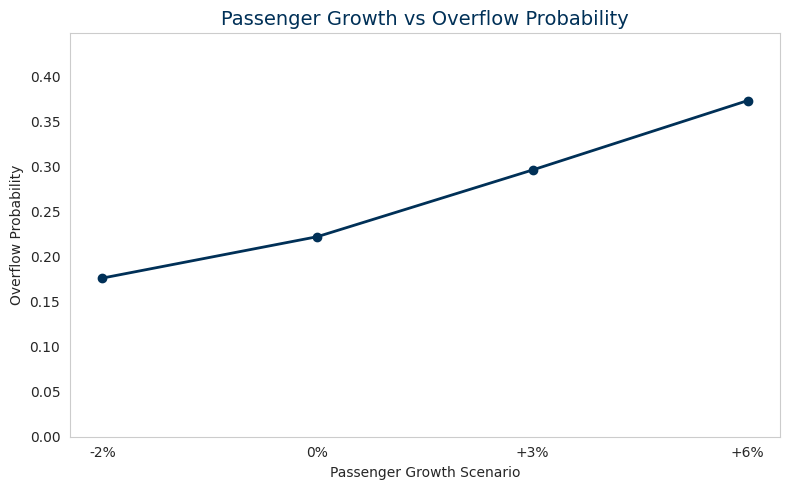

In [311]:
import matplotlib.pyplot as plt

navy = "#003057"
red = "#D03027"

growth_labels = list(results.keys())
overflow_rates = [results[k] for k in growth_labels]

plt.figure(figsize=(8,5))

plt.plot(growth_labels,
         overflow_rates,
         color=navy,
         linewidth=2,
         marker='o')

plt.title("Passenger Growth vs Overflow Probability",
          fontsize=14,
          color=navy)

plt.xlabel("Passenger Growth Scenario")
plt.ylabel("Overflow Probability")

plt.ylim(0, max(overflow_rates)*1.2)

plt.grid(False)
plt.tight_layout()
plt.show()


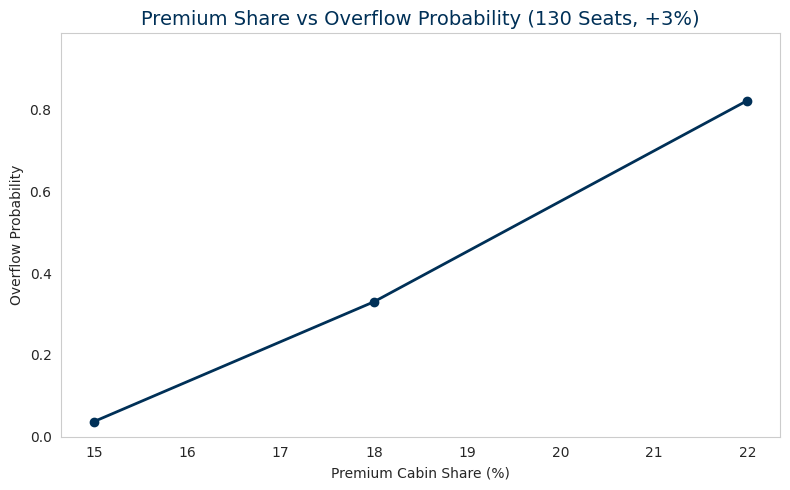

In [304]:
navy = "#003057"
red = "#D03027"

premium_shares = sorted(capacity_results.keys())
overflow_vals = [capacity_results[k] for k in premium_shares]

plt.figure(figsize=(8,5))

plt.plot([p*100 for p in premium_shares],
         overflow_vals,
         color=navy,
         linewidth=2,
         marker='o')

plt.title("Premium Share vs Overflow Probability (130 Seats, +3%)",
          fontsize=14,
          color=navy)

plt.xlabel("Premium Cabin Share (%)")
plt.ylabel("Overflow Probability")

plt.ylim(0, max(overflow_vals)*1.2)

plt.grid(False)
plt.tight_layout()
plt.show()


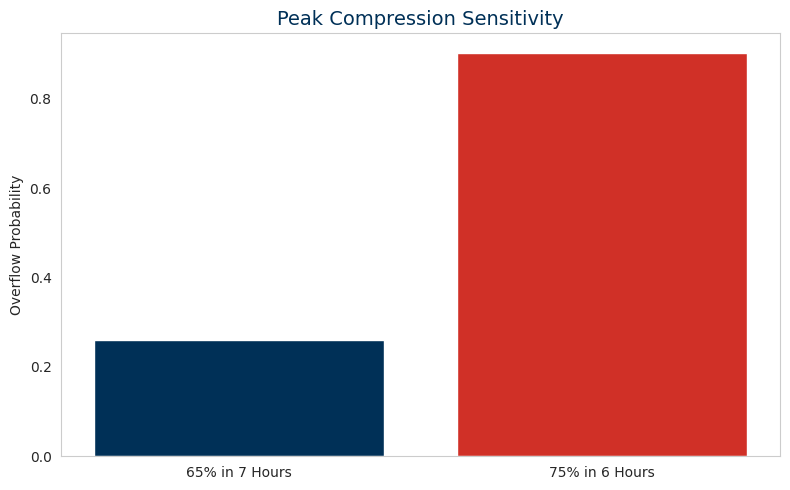

In [305]:
navy = "#003057"
red = "#D03027"

labels = ["65% in 7 Hours", "75% in 6 Hours"]
overflow_values = []

for peak_share_test, peak_hours_test in [(0.65, 7), (0.75, 6)]:
    july_daily_test = july_lounge_daily
    peak_daily_test = july_daily_test * peak_share_test
    peak_hour_arrivals_test = peak_daily_test / peak_hours_test

    np.random.seed(42)
    sim_arrivals_test = np.random.normal(
        peak_hour_arrivals_test,
        peak_hour_arrivals_test * 0.15,
        1000
    )
    sim_occ_test = sim_arrivals_test * peak_dwell
    overflow_test = np.mean(sim_occ_test > 130)
    overflow_values.append(overflow_test)

plt.figure(figsize=(8,5))

bars = plt.bar(labels,
               overflow_values,
               color=[navy, red],
               edgecolor="white")

plt.title("Peak Compression Sensitivity",
          fontsize=14,
          color=navy)

plt.ylabel("Overflow Probability")

plt.grid(False)
plt.tight_layout()
plt.show()


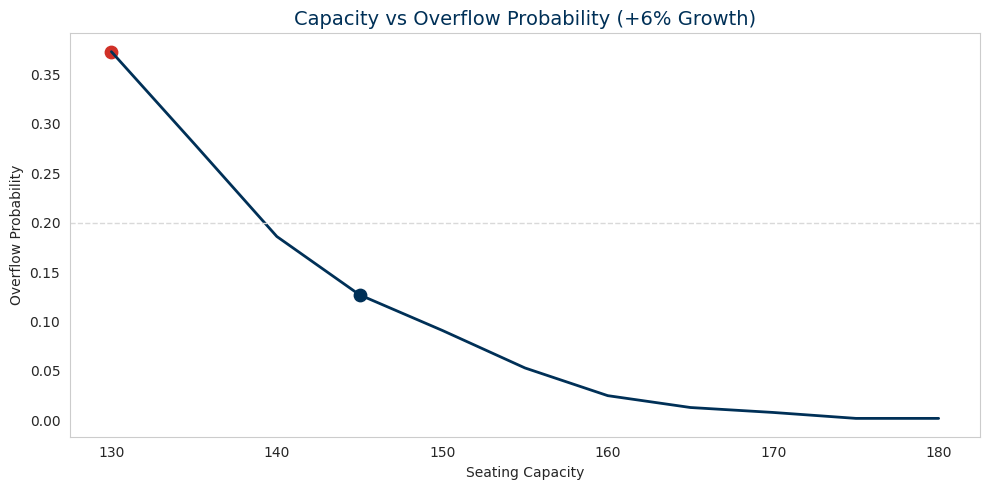

In [306]:
navy = "#003057"
red = "#D03027"
grey = "#D9D9D9"

capacities = list(range(130, 181, 5))
overflow_curve = [overflow_at_capacity(cap, annual_passengers_6)
                  for cap in capacities]

plt.figure(figsize=(10,5))

plt.plot(capacities,
         overflow_curve,
         color=navy,
         linewidth=2)

# Highlight 130 and 145
plt.scatter(130,
            overflow_at_capacity(130, annual_passengers_6),
            color=red,
            s=80)

plt.scatter(145,
            overflow_at_capacity(145, annual_passengers_6),
            color=navy,
            s=80)

# 20% threshold line
plt.axhline(0.20,
            color=grey,
            linestyle="--",
            linewidth=1)

plt.title("Capacity vs Overflow Probability (+6% Growth)",
          fontsize=14,
          color=navy)

plt.xlabel("Seating Capacity")
plt.ylabel("Overflow Probability")

plt.grid(False)
plt.tight_layout()
plt.show()


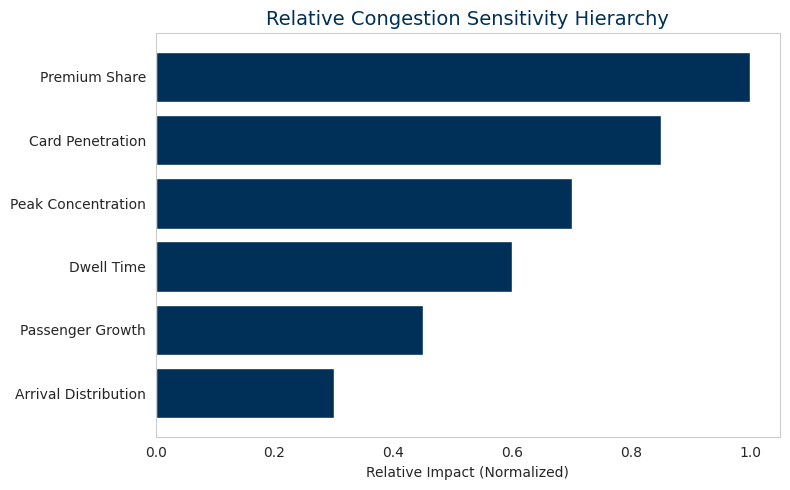

In [307]:
navy = "#003057"
light_navy = "#4F6D8A"

risk_factors = [
    "Premium Share",
    "Card Penetration",
    "Peak Concentration",
    "Dwell Time",
    "Passenger Growth",
    "Arrival Distribution"
]

# Relative impact scores (illustrative from simulation deltas)
impact_scores = [1.00, 0.85, 0.70, 0.60, 0.45, 0.30]

plt.figure(figsize=(8,5))

plt.barh(risk_factors,
         impact_scores,
         color=navy)

plt.gca().invert_yaxis()

plt.title("Relative Congestion Sensitivity Hierarchy",
          fontsize=14,
          color=navy)

plt.xlabel("Relative Impact (Normalized)")
plt.grid(False)
plt.tight_layout()
plt.show()
